In [ ]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
import shutil

sys.path.append('/jet/home/tvnguyen/accreted_catalog/gaia_accreted_catalog')

import ml_collections
import numpy as np
import scipy.special as special
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from ml_collections import config_flags
from memory_profiler import profile

import datasets
from models import models, classifier, utils, infer_utils

%matplotlib inline
plt.style.use('/jet/home/tvnguyen/mplstyle/default.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# read in the model
logdir = '/ocean/projects/phy210068p/tvnguyen/accreted_catalog/logging'
name = 'greasy-vote-10'
checkpoint = 'epoch=51-step=1100164.ckpt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

checkpoint_path = os.path.join(logdir, name, 'lightning_logs/checkpoints', checkpoint)
model = classifier.MLPClassifier.load_from_checkpoint(
    checkpoint_path, map_location=device)

# read in the dataset and prepare the data loader for training
data_root = '/ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets'
data_name = 'GaiaDR3_transfer'
data_features = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
seed = 45
train_frac = 0.9

data_dir = os.path.join(data_root, data_name)
train_loader, val_loader, norm_dict, class_weights = datasets.prepare_dataloader(
    data_dir, data_features,
    num_datasets=10,
    subsample_factor=1,
    train_frac=train_frac,
    train_batch_size=8192,
    eval_batch_size=8192,
    num_workers=1,
    seed=seed,  # reset seed for splitting train/val
)

[rank: 0] Global seed set to 45


Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.0.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.1.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.2.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.3.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.4.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.5.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.6.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data.7.hdf5
Reading in data from /ocean/projects/phy210068p/tvnguyen/accreted_catalog/datasets/GaiaDR3_transfer/data

In [4]:
y_pred, y_true = infer_utils.infer(model, val_loader, softmax=False, to_numpy=True)
y_pred_score = special.softmax(y_pred, axis=1)
y_pred_score = y_pred_score[..., 1]

Inferencing: 100%|█████████████████████████████████████████████████████| 294/294 [00:29<00:00,  9.85it/s]


In [5]:
# save the results
results = {
    'y_true': y_true,
    'y_pred': y_pred,
    'y_pred_score': y_pred_score,
    'norm_dict': norm_dict,
    'class_weights': class_weights,
}
results_path = os.path.join(logdir, name, 'results.val.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(results, f)

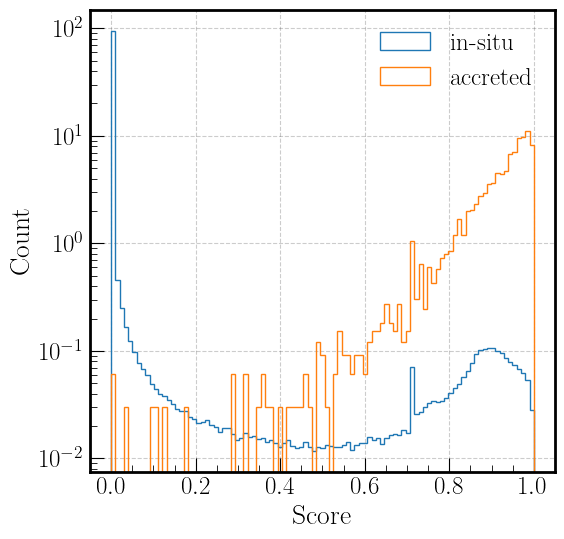

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = np.linspace(0, 1, 100)
ax.hist(
    y_pred_score[y_true==0], bins=bins, density=True,
    histtype='step', label='in-situ', color='C0')
ax.hist(
    y_pred_score[y_true==1], bins=bins, density=True,
    histtype='step', label='accreted', color='C1')

ax.set_xlabel('Score')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.legend()

plt.show()

In [7]:
# get ROC curve
def roc_curve(y_true, y_score, thresholds):
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred = (y_score > threshold)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    return np.array(fpr), np.array(tpr)

def eff(y_true, y_score, thresholds):
    """ Get the efficiency and purity for a given threshold """
    epsilon_0 = []  # efficiency for class 0
    epsilon_1 = []  # efficiency for class 1
    purity = []  # purity for class 1
    for threshold in thresholds:
        y_pred = (y_score > threshold)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        tn = np.sum((y_pred == 0) & (y_true == 0))
        fn = np.sum((y_pred == 0) & (y_true == 1))

        epsilon_0.append(fp / (tn + fp))
        epsilon_1.append(tp / (tp + fn))
        purity.append(tp / (tp + fp))
    return np.array(epsilon_0), np.array(epsilon_1), np.array(purity)

In [8]:
thresholds = np.linspace(0.001, 1, 100)
eps_i, eps_a, purity = eff(y_true, y_pred_score, thresholds)

/tmp/ipykernel_40626/596842009.py:29: RuntimeWarning: invalid value encountered in scalar divide
  purity.append(tp / (tp + fp))


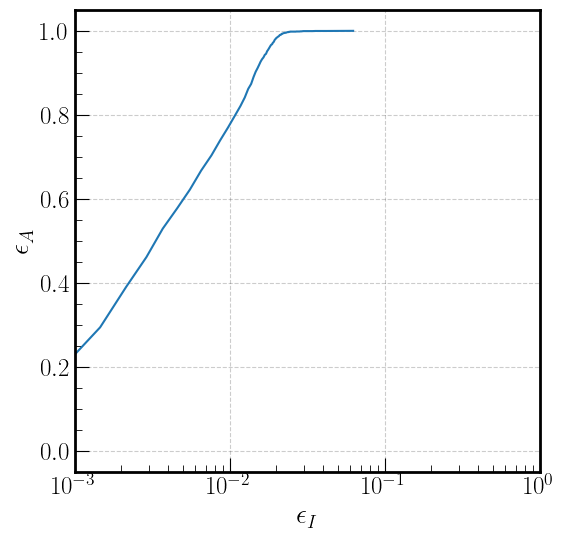

In [9]:
fig, ax = plt.subplots()

ax.plot(eps_i, eps_a)
ax.set_xlabel(r'$\epsilon_{I}$')
ax.set_ylabel(r'$\epsilon_{A}$')
ax.set_xscale('log')
ax.set_xlim(1e-3, 1)

plt.show()